In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Data paths
dataset_path = '/kaggle/input/diamond'  # Replace with your dataset path

# Image dimensions
img_width, img_height = 150, 150  # Adjust as needed

# Preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equalized = cv2.equalizeHist(gray)
    return cv2.resize(equalized, (img_width, img_height))

# Load and preprocess images
X = []
y = []
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for image_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, image_name)
        try:
            img_data = preprocess_image(img_path)
            X.append(img_data)
            y.append(folder)  # Use folder name as label
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")  # Handle errors gracefully

# Convert to numpy arrays
X = np.array(X).astype('float32') / 255.0
y = np.array(y)

# Reshape X to have rank 4
X = np.expand_dims(X, axis=-1)

# One-hot encode labels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))




/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


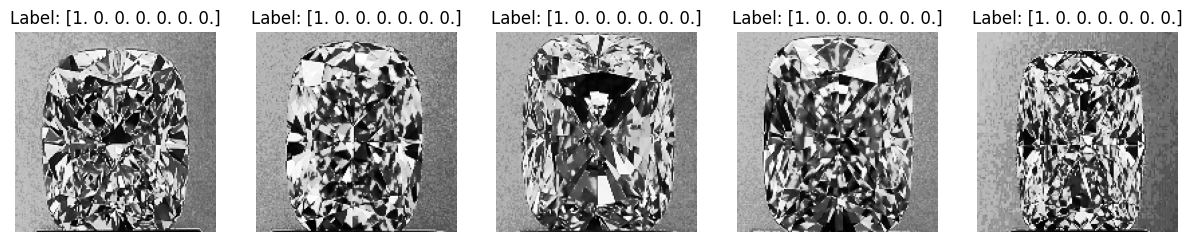

In [5]:
import matplotlib.pyplot as plt

# Display some pre-processed images
num_examples = 5  # Number of examples to display
fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))

for i in range(num_examples):
    axes[i].imshow(X[i], cmap='gray')
    axes[i].set_title(f'Label: {y[i]}')
    axes[i].axis('off')

plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

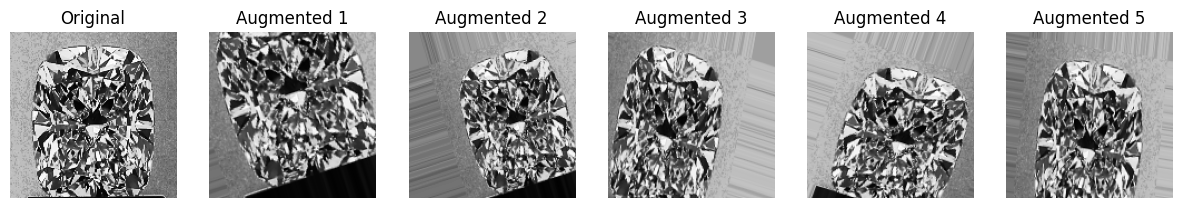

In [7]:
# Creating CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')  # Output layer for 7 classes
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Choose an image from your dataset to augment and visualize
sample_image_index = 0  # Change this index as needed

# Generate augmented images
augmented_images = []
for batch in train_datagen.flow(np.expand_dims(X[sample_image_index], axis=0), batch_size=1):
    augmented_images.append(batch[0])
    if len(augmented_images) >= 5:  # Display 5 augmented images
        break

# Display original and augmented images
plt.figure(figsize=(15, 4))

# Original image
plt.subplot(1, 6, 1)
plt.imshow(X[sample_image_index].squeeze(), cmap='gray')
plt.title('Original')
plt.axis('off')

# Augmented images
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(augmented_images[i].squeeze(), cmap='gray')
    plt.title(f'Augmented {i + 1}')
    plt.axis('off')

plt.show()

Spliting Done
Epoch 1/25
219/219 [==============================] - 23s 69ms/step - loss: 1.9774 - accuracy: 0.1937 - val_loss: 1.7623 - val_accuracy: 0.2320
Epoch 2/25
219/219 [==============================] - 15s 67ms/step - loss: 1.8489 - accuracy: 0.2266 - val_loss: 1.7578 - val_accuracy: 0.2794
Epoch 3/25
219/219 [==============================] - 15s 67ms/step - loss: 1.7694 - accuracy: 0.2706 - val_loss: 1.6905 - val_accuracy: 0.2971
Epoch 4/25
219/219 [==============================] - 15s 67ms/step - loss: 1.7021 - accuracy: 0.2921 - val_loss: 1.6241 - val_accuracy: 0.3051
Epoch 5/25
219/219 [==============================] - 15s 66ms/step - loss: 1.6424 - accuracy: 0.3059 - val_loss: 1.6003 - val_accuracy: 0.3126
Epoch 6/25
219/219 [==============================] - 15s 67ms/step - loss: 1.5175 - accuracy: 0.3483 - val_loss: 0.9233 - val_accuracy: 0.6286
Epoch 7/25
219/219 [==============================] - 15s 66ms/step - loss: 1.0302 - accuracy: 0.5913 - val_loss: 0.4437 -

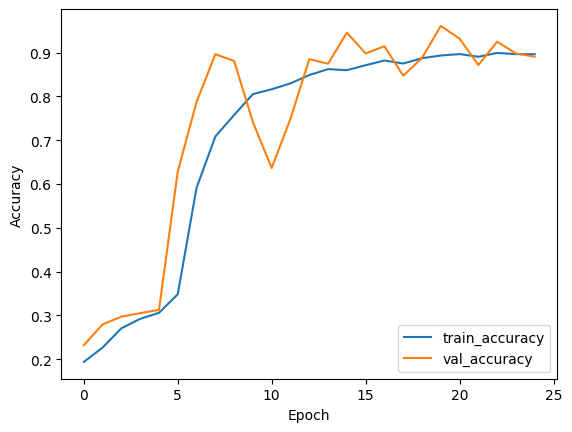

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split the data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Spliting Done')

# Train the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=25,
    validation_data=(X_test, y_test)
)

# Plot training history (optional)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [10]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)



55/55 [==============================] - 0s 3ms/step


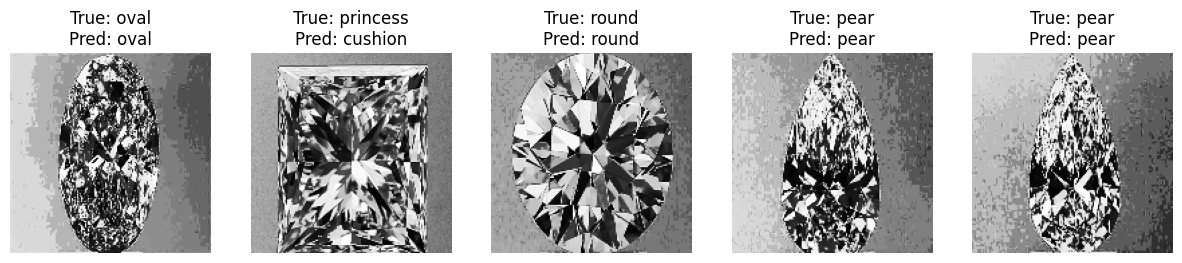

In [11]:
# Function to display images along with true and predicted labels
def show_predictions(images, true_labels, pred_labels):
    plt.figure(figsize=(15, 5))
    for i in range(min(5, len(images))):  # Display up to 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        title = f'True: {label_encoder.classes_[true_labels[i]]}\nPred: {label_encoder.classes_[pred_labels[i]]}'
        plt.title(title)
        plt.axis('off')
    plt.show()

# Show predictions on a subset of the test set
show_predictions(X_test, y_true_classes, y_pred_classes)


In [13]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.98      0.76       260
           1       0.98      1.00      0.99       258
           2       0.99      0.99      0.99       252
           3       0.90      0.96      0.93       249
           4       1.00      0.96      0.98       253
           5       0.99      0.41      0.58       242
           6       1.00      0.92      0.96       236

    accuracy                           0.89      1750
   macro avg       0.93      0.89      0.88      1750
weighted avg       0.92      0.89      0.88      1750



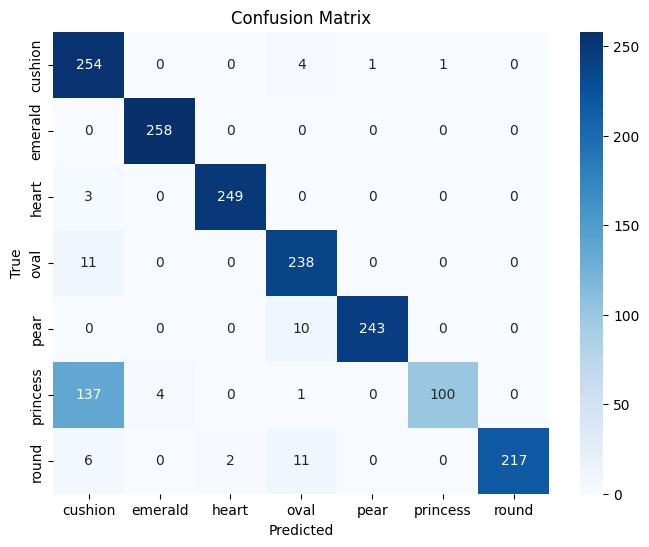

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
# Save the trained model
model.save('diamond_classifier.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
